# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Используемые библиотеки

In [1]:
!pip install -Uq scikit-learn
!pip install matplotlib==3.5.0 -q
!pip install phik

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet

from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [3]:
def check_data(df, name):
    """
    Проверяет информацию о каждом DataFrame (типы данных, пропущенные значения, полные дубликаты строк).
    
    Параметры:
        df (pd.DataFrame): Исходный датафрейм
        name (str): Названия датафрейма
    
    """
    print(f"Информация о {name}:")
    df.info()
    print(f"Пропущенные значения в {name}:")
    display(df.isnull().sum())
    print(f"Дубликаты в {name}: {df.duplicated().sum()}")

In [4]:
def duplicated_values(df, df_name):
    """
    Проверяет дубликаты по столбцам
    
    Параметры:
        df (pd.DataFrame): Исходный датафрейм
        df_name (str): Названия датафрейма
    
    """
    print(f"Дубликаты таблицы {df_name}:")
    for col in df.select_dtypes(include='object').columns:
        duplic_values = df[col].duplicated().sum()
        print(f"Столбцы '{col}': {duplic_values}")

In [5]:
def remove_outliers(dataframe, column, verbose=True):
    """
    Удаляет выбросы из указанного столбца датафрейма на основе метода межквартильного размаха (IQR).
    
    Параметры:
        dataframe (pd.DataFrame): Исходный датафрейм.
        column (str): Название столбца, из которого нужно удалить выбросы.
        verbose (bool): Если True, выводит количество найденных выбросов и их процент от общего числа строк.
    
    Возвращает:
        list: Индексы строк с выбросами.
    """
    q1 = dataframe[column].quantile(0.25)  # Первый квартиль (25%)
    q3 = dataframe[column].quantile(0.75)  # Третий квартиль (75%)
    iqr = q3 - q1  # Межквартильный размах

    lower_bound = q1 - 1.5 * iqr  # Нижняя граница
    upper_bound = q3 + 1.5 * iqr  # Верхняя граница

    # Вычисление индексов строк с выбросами
    outlier_indices = dataframe[
        (dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)
    ].index.tolist()

    if verbose:
        num_outliers = len(outlier_indices)
        total_rows = len(dataframe)
        outlier_percentage = (num_outliers / total_rows) * 100
        print(f'Количество строк с выбросами в столбце "{column}": {num_outliers}')
        print(f'Процент выбросов от общего числа строк: {outlier_percentage:.2f}%')

    return outlier_indices


In [6]:
def calculate_profit(predictions, target, budget, income_per_thousand_barrels, selected_points):
    """
    Расчёт прибыли для выбранных скважин.
    
    Параметры:
        predictions (pandas.Series): Предсказанные значения объёма сырья для всех скважин.
        target (pandas.Series): Истинные значения объёма сырья для скважин.
        budget (float): Общий бюджет на разработку.
        income_per_thousand_barrels (float): Доход от 1000 баррелей сырья.
        selected_points (int): Количество скважин, которые будут выбраны для разработки.
    
    Возвращает: 
        profit (float): Прибыль с выбранных скважин.
    """
    # Выбираем скважины с максимальными предсказаниями
    selected_indices = predictions.nlargest(selected_points).index
    selected_volume = target[selected_indices].sum()
    
    # Расчёт прибыли
    revenue = selected_volume * income_per_thousand_barrels
    profit = revenue - budget

    return profit

In [7]:
def bootstrap_profit(predictions, target, budget, income_per_thousand_barrels, selected_points, total_points, n_bootstrap=1000):
    """
    Бутстреп-анализ прибыли.
    
    Параметры:
        predictions (pandas.Series): Предсказанные значения объёма сырья для всех скважин.
        target (pandas.Series): Истинные значения объёма сырья для скважин.
        budget (float): Общий бюджет на разработку.
        income_per_thousand_barrels (float): Доход от 1000 баррелей сырья.
        selected_points (int): Количество скважин, которые будут выбраны для разработки.
        total_poins (int): Общее количество скважин для исследования.
        n_bootstrap (int, default=1000): Количество случайных выборок, создаваемых бутстрепом.

    Возвращает:
        mean_profit (float): Средняя прибыль по результатам бутстрепа.
        confidence_interval (tuple): Доверительный интервал.
        risk_of_loss (float): Вероятность убытков (доля бутстреп-выборок с отрицательной прибылью).
    """
    state = np.random.RandomState(12345)
    profits = []
    
    for _ in range(n_bootstrap):
        # Создаём случайную выборку
        sample_target = target.sample(n=total_points, replace=True, random_state=state)
        sample_predictions = predictions[sample_target.index]
        
        # Вычисляем прибыль
        profit = calculate_profit(sample_predictions, sample_target, budget, income_per_thousand_barrels, selected_points)
        profits.append(profit)
    
    profits = pd.Series(profits)
    mean_profit = profits.mean()
    lower_quartile = np.percentile(profits, 2.5)  # Нижний граница
    upper_quartile = np.percentile(profits, 97.5)
    #risk_of_loss = profits.apply(lambda x: x < 0).sum()/len(profits)*100,"%"  # Доля убыточных сценариев
    
    print(f"--- Результаты бутстреп-анализа ---")
    print(f"Средняя прибыль: {mean_profit:,.2f} руб.")
    print(f"Квартильный диапазон (2.5% - 97.5%): {lower_quartile:,.2f} руб. - {upper_quartile:,.2f} руб.")
    print(f"Риск убытков: {profits.apply(lambda x: x < 0).sum()/len(profits)*100}")
    print('-'*50)
    
    
    return mean_profit, (lower_quartile, upper_quartile)

In [8]:
RANDOM_STATE = 42

TOTAL_POINTS = 500

SELECTED_POINTS = 200

BUDGET = 10e9

INCOME_PER_BARREL = 450

INCOME_PER_THOUSAND_BARRELS = 45e4

## Загрузка и подготовка данных

In [9]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')

df0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [10]:
df1 = pd.read_csv('/datasets/geo_data_1.csv')

df1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [11]:
df2 = pd.read_csv('/datasets/geo_data_2.csv')

df2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [12]:
check_data(df0, 'df0')

Информация о df0:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Пропущенные значения в df0:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Дубликаты в df0: 0


In [13]:
duplicated_values(df0, 'df0')

Дубликаты таблицы df0:
Столбцы 'id': 10


In [14]:
pd.concat(g for _, g in df0.groupby("id") if len(g) > 1)

,id,f0,f1,f2,product
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675


In [15]:
check_data(df1, 'df1')

Информация о df1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Пропущенные значения в df1:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Дубликаты в df1: 0


In [16]:
duplicated_values(df1, 'df1')

Дубликаты таблицы df1:
Столбцы 'id': 4


In [17]:
pd.concat(g for _, g in df1.groupby("id") if len(g) > 1)

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [18]:
check_data(df2, 'df2')

Информация о df2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Пропущенные значения в df2:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Дубликаты в df2: 0


In [19]:
duplicated_values(df2, 'df2')

Дубликаты таблицы df2:
Столбцы 'id': 4


In [20]:
pd.concat(g for _, g in df2.groupby("id") if len(g) > 1)

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Вывод:

- В датафреймах не обнаружно пропусков, полных дубликатов. Все столбцы имеют нужный тип данных.


- Появилась дилемма, по условию, id - это уникальный индетификатор скважинЫ, но были обнаружены скважины с одними и теме же id, скорее всего, придется убрать эти дубликаты, оставив строки с максимальным product.


- Также нужно добавить новый столбец с регионом, так как данные мы будем объединять, чтобы получить более универсальную модель.

In [21]:
max_product_index = df0.groupby('id')['product'].idxmax()

df0 = df0.loc[max_product_index].reset_index(drop=True)

max_product_index = df1.groupby('id')['product'].idxmax()

df1 = df1.loc[max_product_index].reset_index(drop=True)

max_product_index = df2.groupby('id')['product'].idxmax()

df2 = df2.loc[max_product_index].reset_index(drop=True)

Отобрали строки, дубликатов по id больше нет (взял по максимальному product)

In [22]:
df0['region'] = 'region_0'

df1['region'] = 'region_1'

df2['region'] = 'region_2'

Был добавлен столбец с регионом

Проведем исследовательский анализ данных


In [23]:
quantitative_columns = ['f0', 'f1', 'f2', 'product']

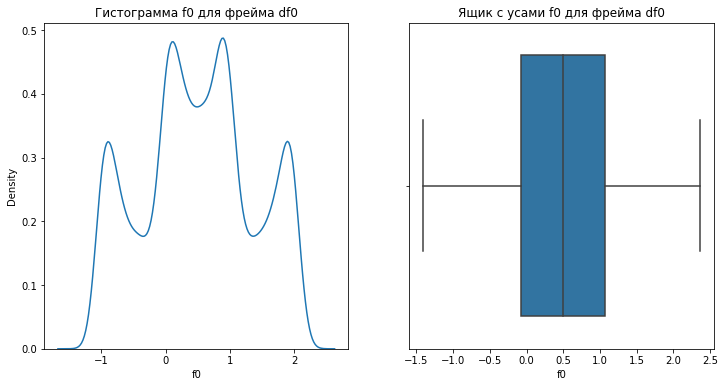

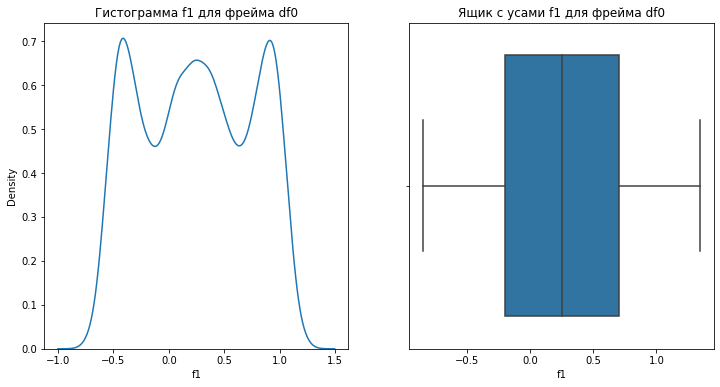

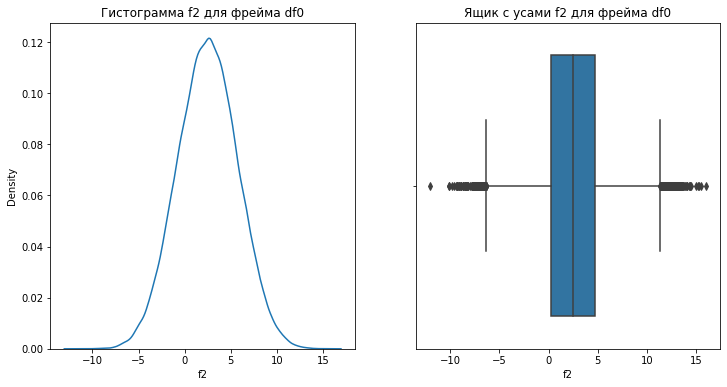

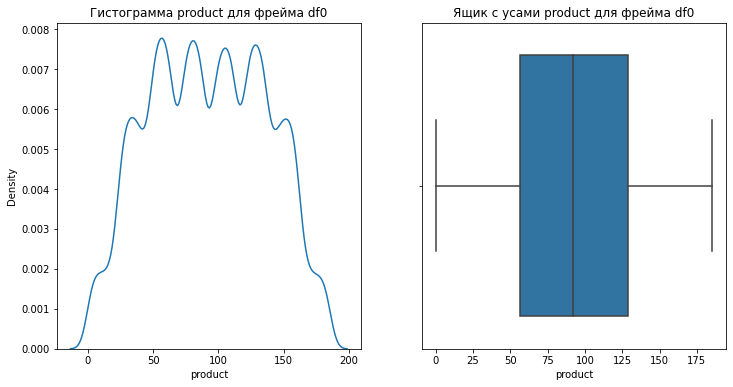

In [24]:
for column in quantitative_columns:
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.kdeplot(df0[column])
    plt.title(f'Гистограмма {column} для фрейма df0')
    
    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df0[column])
    plt.title(f'Ящик с усами {column} для фрейма df0')
    
    plt.show()

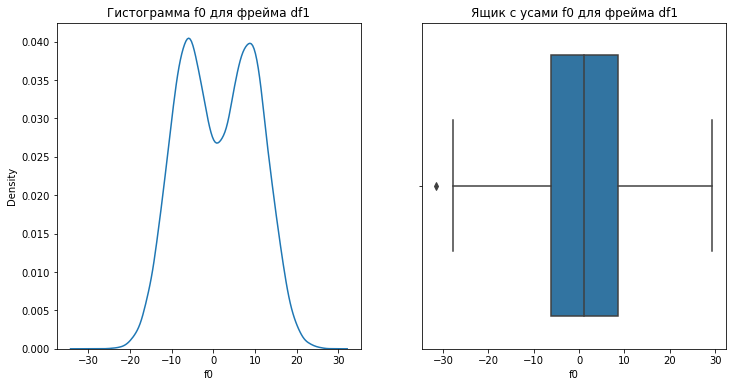

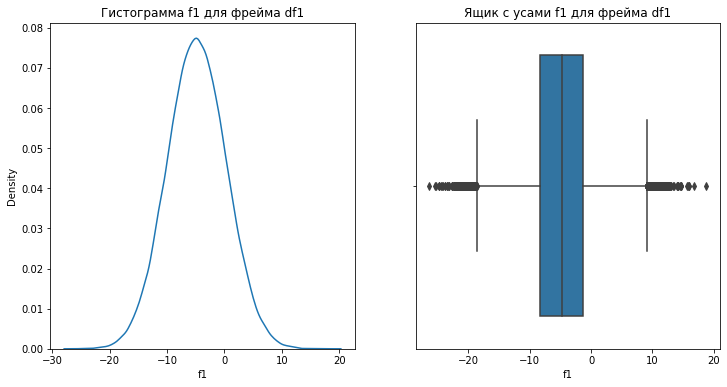

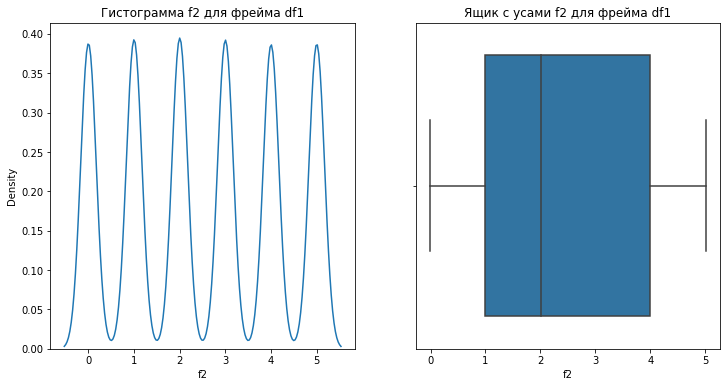

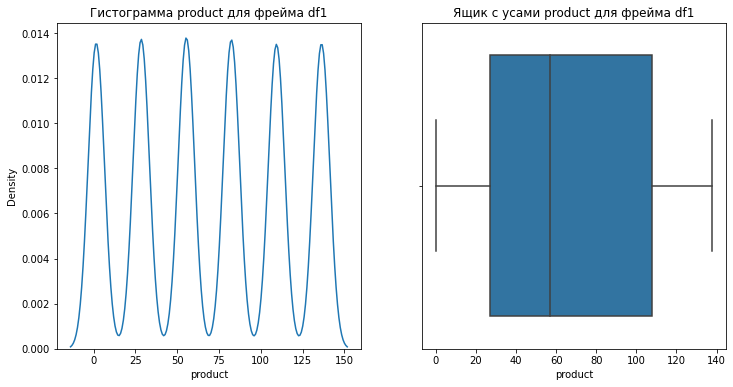

In [25]:
for column in quantitative_columns:
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.kdeplot(df1[column])
    plt.title(f'Гистограмма {column} для фрейма df1')
    
    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df1[column])
    plt.title(f'Ящик с усами {column} для фрейма df1')
    
    plt.show()

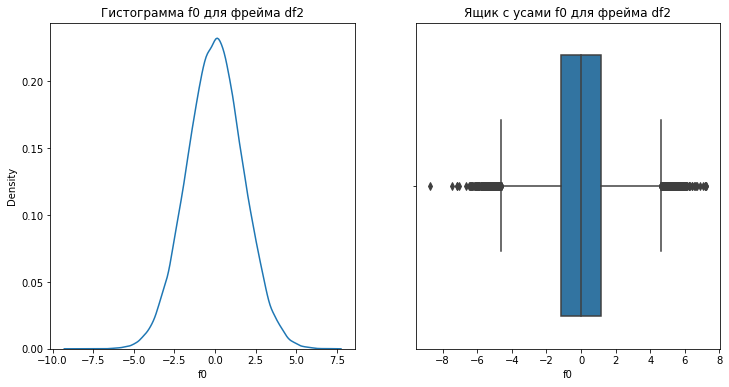

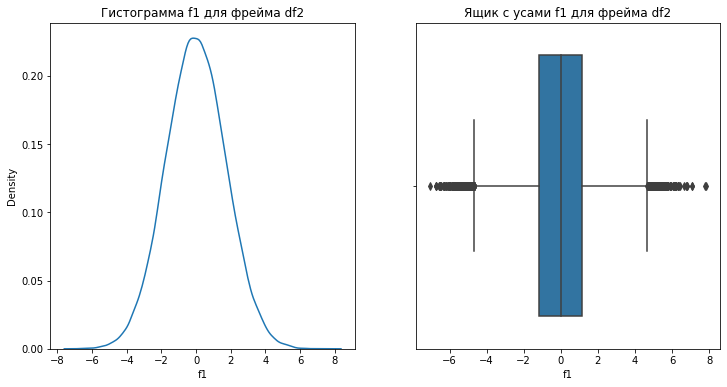

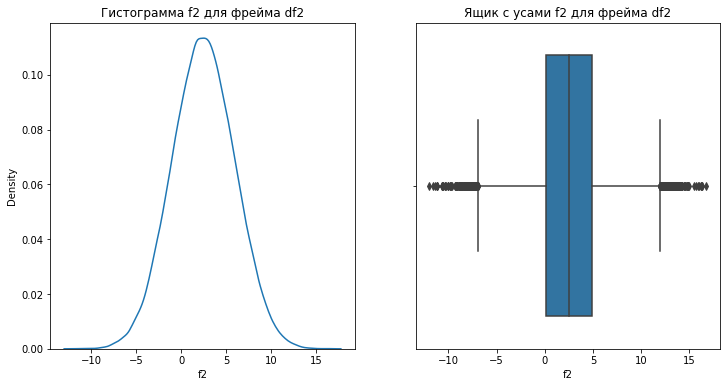

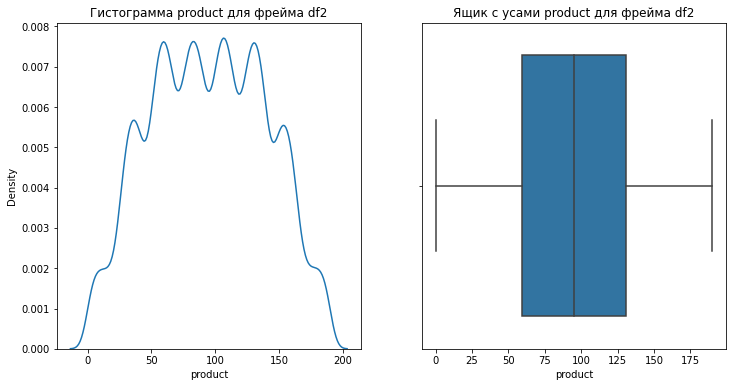

In [26]:
for column in quantitative_columns:
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.kdeplot(df2[column])
    plt.title(f'Гистограмма {column} для фрейма df2')
    
    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df2[column])
    plt.title(f'Ящик с усами {column} для фрейма df2')
    
    plt.show()

Удалим значения, выходящие за 25 и 75 квантили, это позволит обучить модель более качественно, в количестве данных мы особо не теряем

In [27]:
columns_to_check = ['f0', 'f1', 'f2']
for column in columns_to_check:
    outliers = remove_outliers(df0, column)
    df0 = df0.drop(index=outliers)
    print('                 ')

Количество строк с выбросами в столбце "f0": 0
Процент выбросов от общего числа строк: 0.00%
                 
Количество строк с выбросами в столбце "f1": 0
Процент выбросов от общего числа строк: 0.00%
                 
Количество строк с выбросами в столбце "f2": 507
Процент выбросов от общего числа строк: 0.51%
                 


In [28]:
for column in columns_to_check:
    outliers = remove_outliers(df1, column)
    df1 = df1.drop(index=outliers)
    print('                 ')

Количество строк с выбросами в столбце "f0": 1
Процент выбросов от общего числа строк: 0.00%
                 
Количество строк с выбросами в столбце "f1": 636
Процент выбросов от общего числа строк: 0.64%
                 
Количество строк с выбросами в столбце "f2": 0
Процент выбросов от общего числа строк: 0.00%
                 


In [29]:
for column in columns_to_check:
    outliers = remove_outliers(df2, column)
    df2 = df2.drop(index=outliers)
    print('                 ')

Количество строк с выбросами в столбце "f0": 733
Процент выбросов от общего числа строк: 0.73%
                 
Количество строк с выбросами в столбце "f1": 682
Процент выбросов от общего числа строк: 0.69%
                 
Количество строк с выбросами в столбце "f2": 582
Процент выбросов от общего числа строк: 0.59%
                 


Удалив значения, выходящие за 25 и 75 квантили, мы получили более качественные датафреймы, что позволит лучше обучить модель.

Потери данных при этом составили не более 2 процентов на датафрейм.

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']
interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']
interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


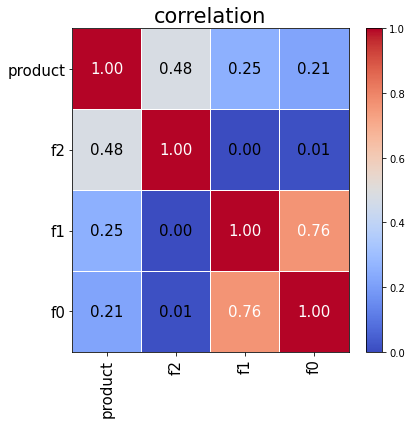

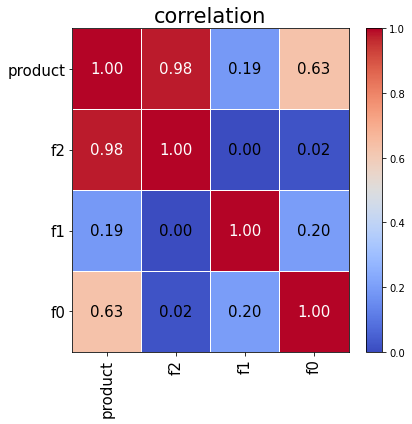

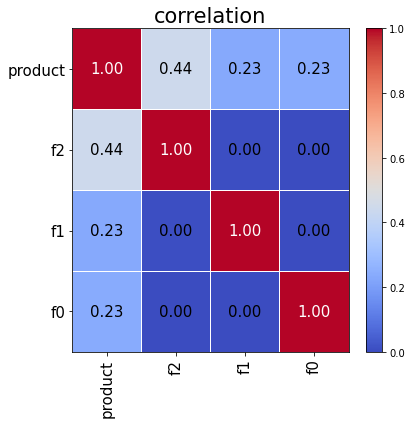

In [30]:
for df in [df0, df1, df2]:
    data_phik = df.set_index('id')
    
    data_phik = data_phik.drop(['region'], axis=1)
    
    phik_overview = phik_matrix(data_phik)
    
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='coolwarm',
        fontsize_factor=1.5,
        figsize=(6, 6)
    )

Выводы:

- Обнаружено странное распределение у признаков f2 и product в df1


- Возможна утечка целевого признака в df1, так как корреляция между f2 и целевым product достигает 0.98. Удалим признак f2.

## Обучение и проверка модели

In [31]:
train_data0, valid_data0 = train_test_split(df0, test_size=0.25, random_state=RANDOM_STATE)

target_train0 = train_data0['product']
target_valid0 = valid_data0['product']

train_features0 = train_data0.drop(['region', 'product', 'id'], axis=1)
valid_features0 = valid_data0.drop(['region', 'product', 'id'], axis=1)


train_data1, valid_data1 = train_test_split(df1, test_size=0.25, random_state=RANDOM_STATE)

target_train1 = train_data1['product']
target_valid1 = valid_data1['product']

train_features1 = train_data1.drop(['region', 'product', 'id'], axis=1)
valid_features1 = valid_data1.drop(['region', 'product', 'id'], axis=1)


train_data2, valid_data2 = train_test_split(df2, test_size=0.25, random_state=RANDOM_STATE)

target_train2 = train_data2['product']
target_valid2 = valid_data2['product']

train_features2 = train_data2.drop(['region', 'product', 'id'], axis=1)
valid_features2 = valid_data2.drop(['region', 'product', 'id'], axis=1)

In [32]:
num_columns_0 = ['f0', 'f1', 'f2']
num_columns_1 = ['f0', 'f1', 'f2']      
num_columns_2 = ['f0', 'f1', 'f2']

# упакуем в список для удобства
datasets = [
    ("Dataset 0", train_features0, target_train0, valid_features0, num_columns_0),
    ("Dataset 1", train_features1, target_train1, valid_features1, num_columns_1),
    ("Dataset 2", train_features2, target_train2, valid_features2, num_columns_2)
]

In [33]:
num_pipe = Pipeline(
    [
    ('simpleImputer_num', SimpleImputer(strategy='median')),
    ('scaler_standard', StandardScaler()),  
    ('scaler_minmax', MinMaxScaler())   
    ]
)

In [34]:
param_grid = [
        # ElasticNet Regression
    {
        'models': [ElasticNet(random_state=RANDOM_STATE)],
        'models__alpha': [0.01, 0.1, 0.5, 1.0, 10.0, 100.0],
        'models__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # LinearRegression
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [35]:
results_train = {}

for name, train_features, train_target, valid_features, num_columns in datasets:
    print(f"Processing {name}...")
    
    # Обновляем числовые признаки в ColumnTransformer
    data_preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipe, num_columns),
        ],
        remainder='passthrough'
    )
    
    # Обновляем основной pipeline
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', ElasticNet(random_state=RANDOM_STATE))
    ])
    
    # Создаем RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipe_final, 
        param_distributions=param_grid, 
        scoring='neg_root_mean_squared_error',
        cv=6,
        n_jobs=-1,
        n_iter=50,
        random_state=RANDOM_STATE
    )
    
    # Обучаем RandomizedSearchCV на текущем наборе данных
    random_search.fit(train_features, train_target)
    
    # Сохраняем результаты
    result = pd.DataFrame(random_search.cv_results_)
    results_train[name] = {
        "cv_results": result,
        "best_model": random_search.best_estimator_,
        "best_score": random_search.best_score_,
        "best_params": random_search.best_params_,
    }
    
    print(f"Best score for {name}: {-random_search.best_score_:.4f}")
    print(f"Best params for {name}: {random_search.best_params_}")
    print('/'*50)


Processing Dataset 0...
Best score for Dataset 0: 37.7558
Best params for Dataset 0: {'preprocessor__num': MinMaxScaler(), 'models': LinearRegression()}
//////////////////////////////////////////////////
Processing Dataset 1...
Best score for Dataset 1: 0.8886
Best params for Dataset 1: {'preprocessor__num': MinMaxScaler(), 'models': LinearRegression()}
//////////////////////////////////////////////////
Processing Dataset 2...
Best score for Dataset 2: 40.0474
Best params for Dataset 2: {'preprocessor__num': 'passthrough', 'models__l1_ratio': 1.0, 'models__alpha': 0.1, 'models': ElasticNet(random_state=42)}
//////////////////////////////////////////////////


In [36]:
datasets = [0, 1, 2]

for i in datasets:
    valid_data = eval(f'valid_data{i}')
    valid_features = eval(f'valid_features{i}')
    best_model = results_train[f'Dataset {i}']['best_model']
    best_score = results_train[f'Dataset {i}']['best_score']
    
    valid_data['pred_product'] = best_model.predict(valid_features)
    rmse = np.sqrt(mean_squared_error(valid_data['product'], valid_data['pred_product']))
    
    print(f'Метрика RMSE для лучшей модели (Dataset {i}): {-best_score}')
    print(f'RMSE для валидационной выборки (Dataset {i}): {rmse}')
    print(f'Средний запас предсказанного сырья (Dataset {i}): {valid_data["pred_product"].mean()}')
    print(f'Средний запас РЕАЛЬНОГО сырья (Dataset {i}): {valid_data["product"].mean()}')
    print('/'*50)

Метрика RMSE для лучшей модели (Dataset 0): 37.75575005869676
RMSE для валидационной выборки (Dataset 0): 37.6468745761372
Средний запас предсказанного сырья (Dataset 0): 92.36620322417748
Средний запас РЕАЛЬНОГО сырья (Dataset 0): 92.16815683223362
//////////////////////////////////////////////////
Метрика RMSE для лучшей модели (Dataset 1): 0.8885780079190004
RMSE для валидационной выборки (Dataset 1): 0.8968322754782144
Средний запас предсказанного сырья (Dataset 1): 69.02404995665546
Средний запас РЕАЛЬНОГО сырья (Dataset 1): 69.02272304205623
//////////////////////////////////////////////////
Метрика RMSE для лучшей модели (Dataset 2): 40.04744811511386
RMSE для валидационной выборки (Dataset 2): 40.25728537411474
Средний запас предсказанного сырья (Dataset 2): 94.86854215305894
Средний запас РЕАЛЬНОГО сырья (Dataset 2): 94.86143851098832
//////////////////////////////////////////////////


Вывод:

- Dataset 0: Лучшая модель — Linear Regression с нормализацией (MinMaxScaler). RMSE на обучении — 37.76, на валидации — 37.65. Средний предсказанный запас сырья — 92.37, средний реальный запас сырья — 92.17.


- Dataset 1: Лучшая модель — Linear Regression с нормализацией (MinMaxScaler). RMSE на обучении — 0.8886, на валидации — 0.8968. Средний предсказанный запас сырья — 69.024, средний реальный запас сырья — 69.02.


- Dataset 2: Лучшая модель — ElasticNet (l1_ratio=1.0, alpha=0.1). RMSE на обучении — 40.05, на валидации — 40.26. Средний предсказанный запас сырья — 94.87, средний реальный запас сырья — 94.86.


Различия между предсказанным и реальным запасом сырья во всех случаях минимальны

## Подготовка к расчёту прибыли

In [37]:
sufficient_volume = BUDGET / (INCOME_PER_THOUSAND_BARRELS * SELECTED_POINTS)

In [38]:
print(f'Достаточный объем сырья для безубыточной разработки новой скважины: {round(sufficient_volume, 2)}')

Достаточный объем сырья для безубыточной разработки новой скважины: 111.11


Вывод:

- Средний объём сырья во всех регионах ниже уровня безубыточности (111.11 тыс. баррелей), что указывает на риск убытков при разработке новых скважин.


- Наиболее низкий запас предсказан в Dataset 1, что делает этот регион наименее привлекательным, но из за прямой корреляции признака f1 с целевой переменной, мы получили наилучший показатель RMSE в 0.88


- Dataset 0 и Dataset 2 показывают близкие значения среднего запаса сырья, но всё же их объём не достигает порога для покрытия затрат.


- Метрика RMSE (ошибка модели) достаточно велика у Dataset 0 и Dataset 2, что увеличивает неопределённость в оценках. Особенно высокая ошибка у Dataset 2, что снижает доверие к прогнозам для этого региона.


- Так как различия между предсказанным средним и реальным средним для каждого региона минимальны, то текст выше актуален как для предсказанных так и для с реальных значений.

## Расчёт прибыли и рисков 

In [39]:
for i in datasets:
    valid_data = eval(f'valid_data{i}')
    print(f'Регион номер {i}')
    print('Прибыль с 200 лучших скважин:', round(calculate_profit(valid_data['pred_product'],
                                                           valid_data['product'],
                                                           BUDGET,
                                                           INCOME_PER_THOUSAND_BARRELS,
                                                           SELECTED_POINTS)))
    print('-'*50)

Регион номер 0
Прибыль с 200 лучших скважин: 3320215552
--------------------------------------------------
Регион номер 1
Прибыль с 200 лучших скважин: 2415086697
--------------------------------------------------
Регион номер 2
Прибыль с 200 лучших скважин: 2386909268
--------------------------------------------------


In [40]:
for i in datasets:
    valid_data = eval(f'valid_data{i}')
    print(f'Регион номер {i}')
    bootstrap_profit(valid_data['pred_product'], valid_data['product'],
                     BUDGET, INCOME_PER_THOUSAND_BARRELS, SELECTED_POINTS, TOTAL_POINTS, n_bootstrap=1000)
    print('-'*50)

Регион номер 0
--- Результаты бутстреп-анализа ---
Средняя прибыль: 616,264,906.81 руб.
Квартильный диапазон (2.5% - 97.5%): 2,919,225.83 руб. - 1,229,660,714.15 руб.
Риск убытков: 2.4
--------------------------------------------------
--------------------------------------------------
Регион номер 1
--- Результаты бутстреп-анализа ---
Средняя прибыль: 644,667,592.61 руб.
Квартильный диапазон (2.5% - 97.5%): 136,608,843.67 руб. - 1,198,307,125.68 руб.
Риск убытков: 0.7000000000000001
--------------------------------------------------
--------------------------------------------------
Регион номер 2
--- Результаты бутстреп-анализа ---
Средняя прибыль: 527,274,975.00 руб.
Квартильный диапазон (2.5% - 97.5%): -128,388,140.74 руб. - 1,212,580,167.47 руб.
Риск убытков: 5.0
--------------------------------------------------
--------------------------------------------------


Вывод:

Для разработки скважин рекомендуется выбрать регион 1. Этот регион соответствует всем необходимым критериям для минимизации рисков и получения максимальной прибыли.

- Средняя прибыль в регионе 1 составляет 644,667,592.61 руб. Это наибольший показатель среди всех регионов, что делает его наиболее привлекательным для разработки.
Риск убытков в регионе 1 составляет 0.7%, что значительно ниже установленного порога в 2.4%. Это гарантирует минимизацию вероятности потерь.


Регион 0 также является потенциально привлекательным:

- Средняя прибыль в регионе 0 составляет 616,264,906.81 руб., что лишь немного меньше, чем в регионе 1.
Риск убытков в регионе 2.4%, что находится на грани допустимого порога, но все еще является приемлемым.


Регион 2 следует исключить из рассмотрения:

- Несмотря на положительную среднюю прибыль (527,274,975.00 руб.), риск убытков составляет 5%, что превышает допустимый уровень в 2.4%.
Кроме того, нижняя граница квартильного диапазона указывает на возможные убытки в этом регионе.


Таким образом, для минимизации рисков и получения максимальной прибыли рекомендуется сосредоточиться на разработке региона 1, а регион 0 можно рассмотреть как альтернативу.